# MAIN EXPERIMENT

# AI Football Coach: Human Pose Estimation and Action Recognition Using Knee Joint Angles for Individual Athletic Training Assistance

In [1]:
# Please Install if you want to conduct inference
# !pip install -q git+https://github.com/tensorflow/docs

In [123]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import math
import imageio
import mediapipe as mp

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow_docs.vis import embed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization

In [2]:
three_dim_encoded_train_data = np.load("../../train_data/encoded_data/three_dim_encoded_train_data.npy")
train_labels = np.load("../../train_data/pose_train_labels.npy")

In [3]:
print(f"Three dimensional encoded train data shape: {three_dim_encoded_train_data.shape}")
print(f"Train labels shape:                         {train_labels.shape}")

Three dimensional encoded train data shape: (40, 30, 332)
Train labels shape:                         (40,)


In [4]:
three_dim_encoded_val_data = np.load("../../val_data/encoded_data/three_dim_encoded_val_data.npy")
val_labels = np.load("../../val_data/pose_val_labels.npy")

In [5]:
print(f"Three dimensional encoded val data shape: {three_dim_encoded_val_data.shape}")
print(f"Val labels shape:                         {val_labels.shape}")

Three dimensional encoded val data shape: (17, 30, 332)
Val labels shape:                         (17,)


In [6]:
train_labels_str = np.array(["Good dribbling pose" if x==0 else "Good juggling pose" for x in train_labels])
val_labels_str = np.array(["Good dribbling pose" if x==0 else "Good juggling pose" for x in val_labels])

In [7]:
train_labels_df = pd.DataFrame({"tag": train_labels_str})
train_labels_df.head()

tag
0  Good dribbling pose
1  Good dribbling pose
2  Good dribbling pose
3  Good dribbling pose
4  Good dribbling pose

In [8]:
def process_label(data):    
    label_processor = keras.layers.StringLookup(
        num_oov_indices=0, vocabulary=np.unique(data)
    )
    
    return label_processor

In [9]:
train_label_processor = process_label(train_labels_df["tag"])
train_label_processor.get_vocabulary()

['Good dribbling pose', 'Good juggling pose']

In [10]:
three_dim_encoded_train_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Train a Standard CNN-LSTM Model with Encoded Data

In [11]:
def standard_cnn_lstm():    
    input_shape = three_dim_encoded_train_data.shape   
    inputs = keras.Input(shape=(input_shape[1:]))
    
    conv = keras.layers.Conv1D(8, 3, activation='relu')(inputs)
    lstm = keras.layers.LSTM(16, return_sequences=True, activation='relu')(conv)
    lstm = keras.layers.LSTM(32, return_sequences=False, activation='relu')(lstm)
    outputs = keras.layers.Dense(1, activation='sigmoid')(lstm)
    cnn_lstm_model = keras.Model(inputs, outputs)
    
    # Compile the model
    cnn_lstm_model.compile(
        loss="binary_crossentropy", 
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )
    
    return cnn_lstm_model

In [12]:
standard_cnn_lstm_model = standard_cnn_lstm()
standard_cnn_lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 332)]         0         
                                                                 
 conv1d (Conv1D)             (None, 28, 8)             7976      
                                                                 
 lstm (LSTM)                 (None, 28, 16)            1600      
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 15,881
Trainable params: 15,881
Non-trainable params: 0
_________________________________________________________________


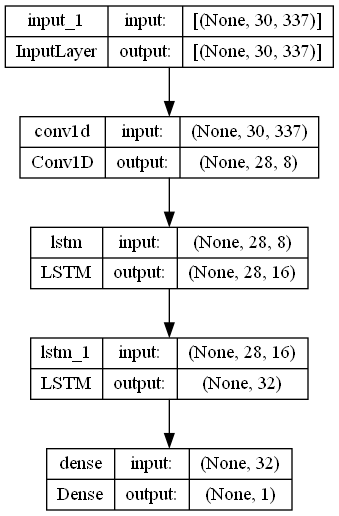

In [24]:
keras.utils.plot_model(standard_cnn_lstm_model, show_shapes=True)

In [13]:
def run_standard_experiment():      
    standard_cnn_lstm_model = standard_cnn_lstm()     
    
    checkpoint_filepath = "training_cp/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_filepath)
    
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True
    )
    
    history = standard_cnn_lstm_model.fit(
        three_dim_encoded_train_data,
        train_labels, 
        validation_data=(three_dim_encoded_val_data, val_labels),
        epochs=200,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
        ]
    )
    
    return history, standard_cnn_lstm_model

In [14]:
standard_cnn_lstm_history, standard_cnn_lstm_model = run_standard_experiment()

Epoch 1/200
2/2 [==============================] - 4s 717ms/step - loss: 0.6936 - accuracy: 0.4500 - val_loss: 0.6931 - val_accuracy: 0.5882
Epoch 2/200
2/2 [==============================] - 0s 186ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6927 - val_accuracy: 0.5882
Epoch 3/200
2/2 [==============================] - 0s 181ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5882
Epoch 4/200
2/2 [==============================] - 0s 165ms/step - loss: 0.6923 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5882
Epoch 5/200
2/2 [==============================] - 0s 178ms/step - loss: 0.6920 - accuracy: 0.5500 - val_loss: 0.6924 - val_accuracy: 0.6471
Epoch 6/200
2/2 [==============================] - 0s 162ms/step - loss: 0.6914 - accuracy: 0.7500 - val_loss: 0.6921 - val_accuracy: 0.6471
Epoch 7/200
2/2 [==============================] - 0s 170ms/step - loss: 0.6909 - accuracy: 0.8250 - val_loss: 0.6917 - val_accuracy: 0.6471
Epoch 8/200
2

## Performance Measures

#### Load saved best model and evaluate

Load the weights from checkpoint and evaluate:

In [11]:
# Load weights 
standard_cnn_lstm_model.load_weights("training_cp/cp.ckpt")

In [20]:
loss, acc = standard_cnn_lstm_model.evaluate(three_dim_encoded_val_data, val_labels, verbose=2)
print("\nBest Accuracy and Loss:\n")
print("Accuracy:", f"{round(acc * 100, 2)}%")
print("Loss:", f"{loss}%")

1/1 - 1s - loss: 0.1368 - accuracy: 0.9412 - 528ms/epoch - 528ms/step

Best Accuracy and Loss:

Accuracy: 94.12%
Loss: 0.13677693903446198%


#### Make some predictions

In [17]:
preds = standard_cnn_lstm_model.predict(three_dim_encoded_val_data)

1/1 [==============================] - 0s 369ms/step


In [18]:
actual = val_labels
# actual

In [19]:
predicted = tf.round(preds)
# predicted

In [20]:
prediction_list = np.array(["Good dribbling pose" if x==0 else "Good juggling pose" for x in predicted])
# prediction_list

#### Confusion Matrix

In [21]:
cm = confusion_matrix(actual, predicted)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[7 0]
 [1 9]]


<AxesSubplot:>

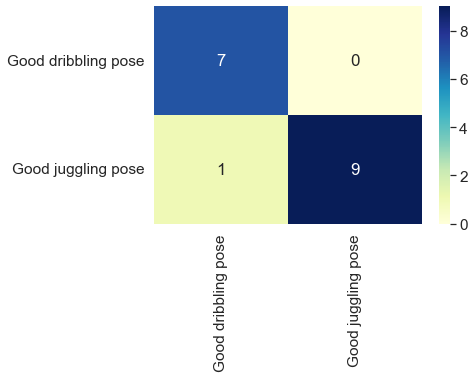

In [22]:
# Visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Good dribbling pose', 'Good juggling pose'], 
                                 index=['Good dribbling pose', 'Good juggling pose'])

sns.set(rc={'figure.figsize':(6, 4)})
sns.set(font_scale=1.4)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#### Classification Report

In [23]:
# Classification report
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.90      0.95        10

    accuracy                           0.94        17
   macro avg       0.94      0.95      0.94        17
weighted avg       0.95      0.94      0.94        17



#### Create DataFrame to Plot Training Accuracy and Loss 

In [18]:
standard_cnn_lstm_hist = pd.DataFrame(standard_cnn_lstm_history.history)
standard_cnn_lstm_hist.head()

In [25]:
# !mkdir plots

#### Plot Training Accuracy and Loss 

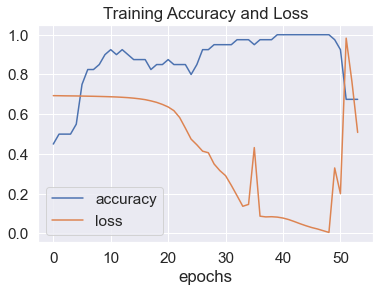

In [26]:
acc_loss = standard_cnn_lstm_hist[["accuracy", "loss"]]
acc_loss.plot(title='Training Accuracy and Loss')
plt.xlabel("epochs")
plt.savefig("plots/Standard CNN-LSTM Training Accuracy and Loss")

#### Plot Validation Accuracy and Loss 

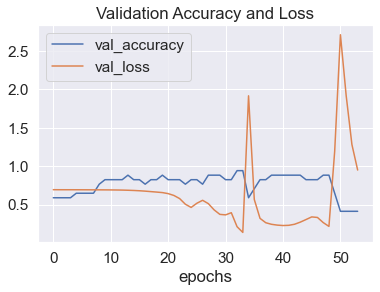

In [27]:
val_acc_loss = standard_cnn_lstm_hist[["val_accuracy", "val_loss"]]
val_acc_loss.plot(title='Validation Accuracy and Loss')
plt.xlabel("epochs")
plt.savefig("plots/Standard CNN-LSTM Validation Accuracy and Loss")

## Save the model

In [28]:
# !mkdir saved_encoded_cnn_lstm_model

In [29]:
standard_cnn_lstm_model.save('saved_encoded_cnn_lstm_model/')

INFO:tensorflow:Assets written to: saved_encoded_cnn_lstm_model/assets


INFO:tensorflow:Assets written to: saved_encoded_cnn_lstm_model/assets


HDF5 Format

In [30]:
standard_cnn_lstm_model.save('saved_encoded_cnn_lstm_model/standard_cnn_lstm_model.h5')

## Hyperparameter Tuning

In [31]:
def tuned_cnn_lstm():    
    input_shape = three_dim_encoded_train_data.shape   
    inputs = keras.Input(shape=(input_shape[1:]))
    
    conv = keras.layers.Conv1D(8, 3, activation='relu')(inputs) 
    # norm = keras.layers.BatchNormalization()(conv)       
    lstm = keras.layers.LSTM(16, return_sequences=True, activation='relu')(conv)
    dropout = keras.layers.Dropout(0.5)(lstm)   
    lstm = keras.layers.LSTM(32, return_sequences=False, activation='relu')(dropout)
    outputs = keras.layers.Dense(1, activation='sigmoid')(lstm)
    tuned_cnn_lstm_model = keras.Model(inputs, outputs)
    
    # Compile the model
    tuned_cnn_lstm_model.compile(
        loss="binary_crossentropy", 
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )
    
    return tuned_cnn_lstm_model

In [32]:
tuned_cnn_lstm_model = tuned_cnn_lstm()
tuned_cnn_lstm_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 332)]         0         
                                                                 
 conv1d_2 (Conv1D)           (None, 28, 8)             7976      
                                                                 
 lstm_4 (LSTM)               (None, 28, 16)            1600      
                                                                 
 dropout (Dropout)           (None, 28, 16)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                6272      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15,881
Trainable params: 15,881
Non-trainable

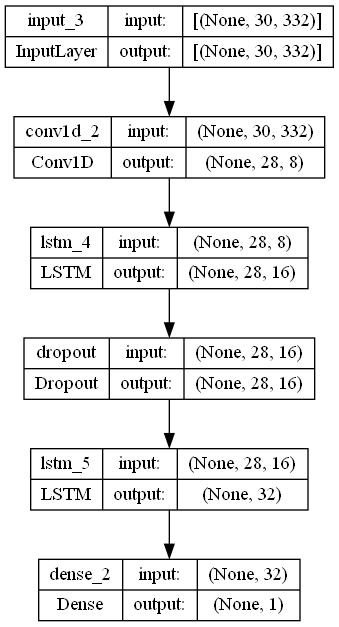

In [33]:
keras.utils.plot_model(tuned_cnn_lstm_model, show_shapes=True)

In [34]:
def run_tuned_experiment():      
    tuned_cnn_lstm_model = tuned_cnn_lstm()     
    
    checkpoint_filepath = "training_cp/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_filepath)
    
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True
    )
    
    history = tuned_cnn_lstm_model.fit(
        three_dim_encoded_train_data,
        train_labels, 
        validation_data=(three_dim_encoded_val_data, val_labels),
        epochs=200,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
        ]
    )
    
    return history, tuned_cnn_lstm_model

In [35]:
tuned_cnn_lstm_history, tuned_cnn_lstm_model = run_tuned_experiment()

Epoch 1/200
2/2 [==============================] - 4s 647ms/step - loss: 0.6933 - accuracy: 0.5750 - val_loss: 0.6935 - val_accuracy: 0.4118
Epoch 2/200
2/2 [==============================] - 0s 156ms/step - loss: 0.6929 - accuracy: 0.6000 - val_loss: 0.6931 - val_accuracy: 0.5882
Epoch 3/200
2/2 [==============================] - 0s 150ms/step - loss: 0.6928 - accuracy: 0.6000 - val_loss: 0.6929 - val_accuracy: 0.5882
Epoch 4/200
2/2 [==============================] - 0s 143ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.5882
Epoch 5/200
2/2 [==============================] - 0s 156ms/step - loss: 0.6923 - accuracy: 0.5250 - val_loss: 0.6924 - val_accuracy: 0.5882
Epoch 6/200
2/2 [==============================] - 0s 159ms/step - loss: 0.6920 - accuracy: 0.5250 - val_loss: 0.6921 - val_accuracy: 0.5882
Epoch 7/200
2/2 [==============================] - 0s 179ms/step - loss: 0.6916 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5882
Epoch 8/200
2

## Performance Measures

#### Load best model

In [36]:
# Load weights 
tuned_cnn_lstm_model.load_weights(f"training_cp/cp.ckpt")

In [37]:
loss, acc = tuned_cnn_lstm_model.evaluate(three_dim_encoded_val_data, val_labels, verbose=2)
print("\nBest Accuracy and Loss\n")
print("Accuracy:", f"{round(acc * 100, 2)}%")
print("Loss:", f"{loss}%")

1/1 - 0s - loss: 0.3652 - accuracy: 0.9412 - 35ms/epoch - 35ms/step

Best Accuracy and Loss

Accuracy: 94.12%
Loss: 0.3651685118675232%


#### Make predictions

In [38]:
tuned_preds = tuned_cnn_lstm_model.predict(three_dim_encoded_val_data)

1/1 [==============================] - 0s 352ms/step


In [39]:
actual = val_labels

In [40]:
tuned_predictions = tf.round(tuned_preds)

In [41]:
tuned_cm = confusion_matrix(actual, tuned_predictions)

print('Tuned Confusion matrix\n\n', tuned_cm)

Tuned Confusion matrix

 [[7 0]
 [1 9]]


<AxesSubplot:>

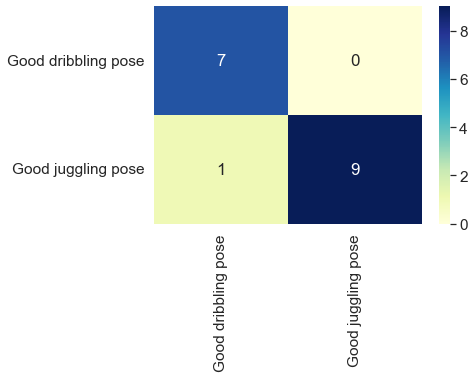

In [42]:
# Visualize confusion matrix with seaborn heatmap

tuned_cm_matrix = pd.DataFrame(data=tuned_cm, columns=['Good dribbling pose', 'Good juggling pose'], 
                                 index=['Good dribbling pose', 'Good juggling pose'])

sns.set(rc={'figure.figsize':(6, 4)})
sns.set(font_scale=1.4)
sns.heatmap(tuned_cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#### Classification Report for Tuned Hyperparameters

In [43]:
# Classification report
print(classification_report(actual, tuned_predictions))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.90      0.95        10

    accuracy                           0.94        17
   macro avg       0.94      0.95      0.94        17
weighted avg       0.95      0.94      0.94        17



In [44]:
tuned_cnn_lstm_hist = pd.DataFrame(tuned_cnn_lstm_history.history)
tuned_cnn_lstm_hist.head()

loss  accuracy  val_loss  val_accuracy
0  0.693269     0.575  0.693476      0.411765
1  0.692942     0.600  0.693129      0.588235
2  0.692795     0.600  0.692867      0.588235
3  0.692608     0.500  0.692578      0.588235
4  0.692299     0.525  0.692375      0.588235

## Plot Tuned Training Accuracy and Losse

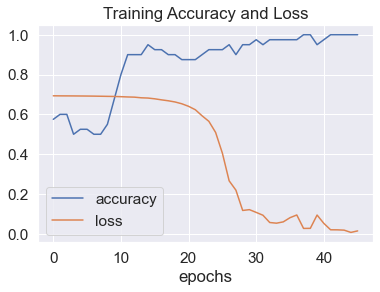

In [45]:
tuned_acc_loss = tuned_cnn_lstm_hist[["accuracy", "loss"]]
tuned_acc_loss.plot(title='Training Accuracy and Loss')
plt.xlabel("epochs")
plt.savefig("plots/Tuned CNN-LSTM Training Accuracy and Loss")

## Plot Tuned Validation Accuracy and Loss

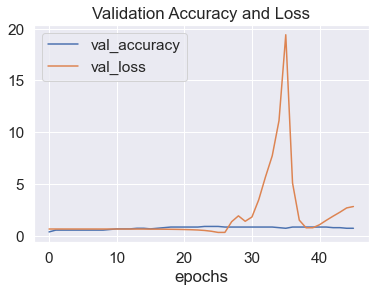

In [46]:
tuned_val_acc_loss = tuned_cnn_lstm_hist[["val_accuracy", "val_loss"]]
tuned_val_acc_loss.plot(title='Validation Accuracy and Loss')
plt.xlabel("epochs")
plt.savefig("plots/Tuned CNN-LSTM Validation Accuracy and Loss")

## Save Tuned Model

In [47]:
# !mkdir saved_tuned_encoded_cnn_lstm_model

Save tuned HDF5 format

In [48]:
tuned_cnn_lstm_model.save('saved_tuned_encoded_cnn_lstm_model/tuned_cnn_lstm_model.h5')

## Inference

In [28]:
def find_pose(img, pose, mp_drawing, mp_pose, draw=True):
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = pose.process(imgRGB)
    coords = {}
    
    if results.pose_landmarks:            
        # Knee
        right_knee_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].x
        right_knee_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE].y
        left_knee_x = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE].x
        left_knee_y = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE].y
        
        right_knee_cor = right_knee_x, right_knee_y
        left_knee_cor = left_knee_x, left_knee_y
        
        coords.update({
            "knee coordinates": {
                "right knee": (right_knee_x, right_knee_y),
                "left knee": (left_knee_x, left_knee_y)
            }
        })
        
    if results.pose_landmarks:
        if draw:
            mp_drawing.draw_landmarks(
                img,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,            
                # Color landmark (the dot color)
                mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=4),
                # Color connection (the line color)
                mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=4),
            )
    imgBGR = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2BGR)
    return img, results, coords

In [29]:
def find_position(img, results):
    pose_list = np.array([[res.x, res.y] for res in results.pose_landmarks.landmark] if results.pose_landmarks else np.zeros((32, 2)))              
    return pose_list

In [30]:
def find_angle(img, p1, p2, p3, pose_list):
    
    # Get the landmarks
    x1, y1 = pose_list[p1]
    x2, y2 = pose_list[p2]
    x3, y3 = pose_list[p3]
    
    # Calculate the Angle
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    if angle < 0:
        angle += 360    
    return angle

In [48]:
def pose_detector(vid, num_frames=15):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    frames = []
    count_frames = 0
    cap = cv2.VideoCapture(vid)
    joint_angles = {
        "right knee": [],
        "left knee": []
                        }
    
    i = 0
    with pose:
        while True:
            success, image = cap.read()
            image = cv2.resize(image, (649, 400))
            if not success:
                print("Ignoring empty camera frame.")
                break             
            
            image, results, coords = find_pose(image, pose, mp_drawing, mp_pose, draw=True)
            pose_list = find_position(image, results)
           
            if len(pose_list) != 0:                
                # Right leg
                right_knee_angles = find_angle(image, 24, 26, 28, pose_list)           
                joint_angles["right knee"].append(int(right_knee_angles))
                
                # Left leg
                left_knee_angles = find_angle(image, 23, 25, 27, pose_list)
                joint_angles["left knee"].append(int(left_knee_angles))                     
        
            count_frames += 1
            i += 1
            
            if num_frames == count_frames:                
                break            
            frames.append(image)
            # Show to screen - Uncomment to see video
            # cv2.imshow('Feed', image)
            
            # Break - End video with letter q on keyboard - Uncomment if you are watching video
            # if cv2.waitKey(10) & 0xFF == ord('q'):
            #     break      
           
    
    cap.release()
    cv2.destroyAllWindows()
    
    return joint_angles, frames

In [134]:
def get_joint_angles(path):    
    players = {}
    sequences = []
    dir_list = os.listdir(path)
    
    for i, vid in enumerate(dir_list):    
        joint_angles, frames= pose_detector(f"{path}/{vid}")
        players[f"joint_angles_{i+1}"] = joint_angles
        sequences.append(frames)
        
    return players, np.array(sequences)

In [74]:
def get_joint_angle_sequences(joint_angles, num_frames=15):    
    players_joint_angles = []
    
    for i, joint_angle in enumerate(joint_angles):
        joint_angle = joint_angles[joint_angle]
        player_joint_angles = []
   
        for j in range(num_frames):            
            player_joint_angles.extend([joint_angle['right knee'][j], joint_angle['left knee'][j]])
        players_joint_angles.append(player_joint_angles) 
        
    return np.array(players_joint_angles)

In [95]:
def three_dim_encode_sequences(sequences, dimension=331):
   
    
    # Initialize an all-zero matrix of shape (length of sequences by dimension of data)
    results = np.zeros((len(sequences), 30, dimension+1)) # +1 to include last element
    
    # Loop through data array
    for i, sequence in enumerate(sequences):
        # Loop through each sequence
        for j, s in enumerate(sequence):            
            # Set specific indices in the results array to 1.
            results[i, j, s] = 1.
            
    return results

In [171]:
test_players, test_frames = get_joint_angles("test_videos")
test_joint_sequences = get_joint_angle_sequences(test_players)
encoded_test_data = three_dim_encode_sequences(test_joint_sequences)

In [107]:
cnn_lstm_model = tf.keras.models.load_model('saved_encoded_cnn_lstm_model/standard_cnn_lstm_model.h5')

In [172]:
preds = cnn_lstm_model.predict(encoded_test_data)   

1/1 [==============================] - 0s 39ms/step


In [174]:
sequence_and_preds = list(zip(test_frames, preds))

## True Predictions

Prediction: Good dribbling pose



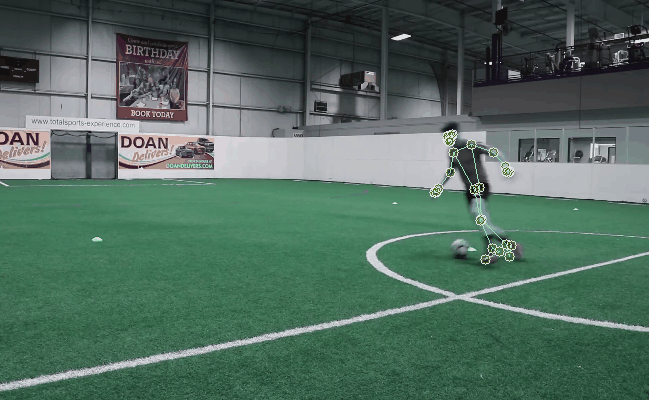

In [189]:
print("Prediction: Good dribbling pose" if sequence_and_preds[0][1][0] < 0.5 else "Prediction: Good juggling pose")
converted_sequences = np.array(sequence_and_preds[0][0]).astype(np.uint8)
imageio.mimsave("animation.gif", converted_sequences, fps=10)
embed.embed_file("animation.gif")

Prediction: Good juggling pose



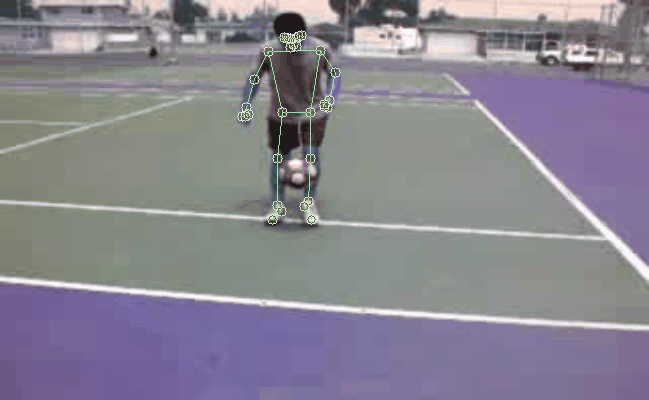

In [190]:
print("Prediction: Good dribbling pose" if sequence_and_preds[1][1][0] < 0.5 else "Prediction: Good juggling pose")
converted_sequences = np.array(sequence_and_preds[1][0]).astype(np.uint8)
imageio.mimsave("animation.gif", converted_sequences, fps=10)
embed.embed_file("animation.gif")

## False Prediction

Prediction: Good dribbling pose



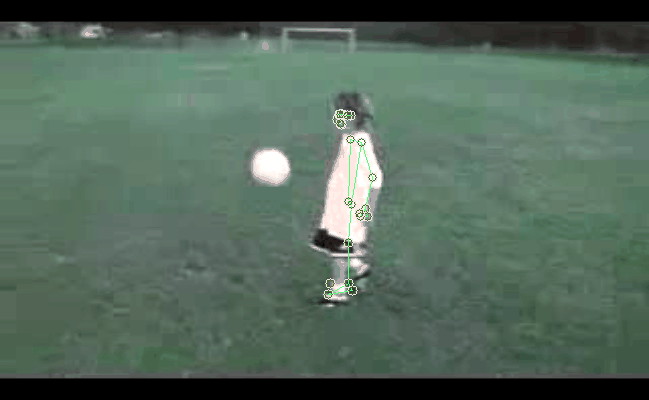

In [191]:
print("Prediction: Good dribbling pose" if sequence_and_preds[2][1][0] < 0.5 else "Prediction: Good juggling pose")
converted_sequences = np.array(sequence_and_preds[2][0]).astype(np.uint8)
imageio.mimsave("animation.gif", converted_sequences, fps=10)
embed.embed_file("animation.gif")